## Notes

High imbalance of classes in BloodPressure (3) and Glucose (3)
### KNN
1. Accuracy decreases by decreasing principal components. Highest at (8)
2. Try regression instead of classification. The ranges defined for BloodPressure and Glucose gives rise to significant imbalance.
3. Try without dimension reduction.

# Libraries

In [438]:
import numpy as np 
import pandas as pd 
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2.0, style="dark")
import warnings 
from sklearn.svm import SVC, NuSVC
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
# from tflearn.data_utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy import interp
from sklearn.metrics import multilabel_confusion_matrix as confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from tensorflow.keras.utils import to_categorical

# Data Manipulation

In [439]:
## Make 1 or True  if you run colab
## Other wise 0 or False
##if you run in  colab

colab = 0
if colab ==True:
  data_dir='/content/drive/MyDrive/PIMA Journal/diabetes.csv'
  from google.colab import drive
  drive.mount('/content/drive')
else:
  
  data_dir='Diabetes_processed.csv'


In [440]:
data = pd.read_csv(data_dir)

In [441]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,171.474227,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.000000,113.606695,26.6,0.351,31.0,0
2,8.0,183.0,64.0,32.059259,171.474227,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0
4,5.0,116.0,74.0,27.094512,113.606695,25.6,0.201,30.0,0


In [442]:
def swap_col(target_):
  swap_data = copy.deepcopy(data)
  swap_data[target_] = data.Outcome
  swap_data.Outcome = data[target_]
  swap_data.rename(columns = {'Outcome':target_, target_: 'Diabetic'}, inplace = True)
  #swap_data.Diabetic.replace({1:'Yes', 0:'No'} , inplace = True)
  return swap_data

In [443]:
data_BP = swap_col('BloodPressure')

#data_ST = swap_col('SkinThickness')
#data_Ins = swap_col('Insulin')
#data_BMI = swap_col('BMI')
#data_DPF = swap_col('DiabetesPedigreeFunction')
#data_Age = swap_col('Age')
#data_Pregnancies = swap_col('Pregnancies')

In [444]:
data_BP.head()

,Pregnancies,Glucose,Diabetic,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,BloodPressure
0,6.0,148.0,1,35.000000,171.474227,33.6,0.627,50.0,72.0
1,1.0,85.0,0,29.000000,113.606695,26.6,0.351,31.0,66.0
2,8.0,183.0,1,32.059259,171.474227,23.3,0.672,32.0,64.0
3,1.0,89.0,0,23.000000,94.000000,28.1,0.167,21.0,66.0
4,5.0,116.0,0,27.094512,113.606695,25.6,0.201,30.0,74.0


In [445]:
knn_res = pd.DataFrame()
random_initializer=100            #random initializer
n_dots=50

# Utility Functions


In [446]:
def metrics (y_true, y_pred, probas_):
  '''
  Parameters :
  Input - 
  y_true - true  value of input data    
  y_pred- predicted  value of input data  
  probas_- probability/confidence of predicted output

  return -True Negative(tn),False Positive(fp),False Negative(fn)
  True positive(tp),AUC(roc_auc),False Positive Rate(fpr),
  True positive rate(tpr)

  '''


  points=n_dots*'-'
  print(points)
#    print("Best parameters set found on development set:")
#    print(clf.best_params_)
  #  aucs.append(roc_auc)
  print("Detailed classification report for current fold:")
  print()
  print(classification_report(y_true, y_pred))
  print()
  print()
  #print('Confusion Matrix for current fold: ')
  #print(confusion_matrix(y_true, y_pred))
  print()
  print("Accuracy for Current Fold: {}".format(accuracy_score(y_true, y_pred)))
  print()

  confusion_array = confusion_matrix(y_true, y_pred)
  confusion_d = pd.DataFrame(confusion_array.reshape(-1, 4), columns=["TN", "FP", "FN", "TP"])
  tn, fp, fn, tp = np.array(confusion_d.TN), np.array(confusion_d.FP), np.array(confusion_d.FN), np.array(confusion_d.TP)

  return  tn, fp, fn, tp


def average_performance(Accuracy,TP,TN,FP,FN): 

  '''
  Parameters :
  Input - 
  Accuracy - value of accuracy
  TP  - True Positive
  TN  - True Negative
  FP  - False Positive
  FN  - False Negative


  Output - 
  It prints the average accuarcy,confusion matrix
  '''

  print()
  n_dotsav=(n_dots-len('Average'))//2
    
  print('-'*n_dotsav+'Average'+'-'*n_dotsav)
  print("Accuracy (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(Accuracy),np.std(Accuracy)))
  cm = [[int(np.mean(TP)), int(np.mean(FP))],[int(np.mean(FN)), int(np.mean(TN))]]
  print ('Avg. CM is '+str(cm))
  cm = [[int(np.sum(TP)), int(np.sum(FP))],[int(np.sum(FN)), int(np.sum(TN))]]
  print ('Total for all folds CM is '+str(cm))

def creat_Model (classifier, X_Train, Y_Train, tuned_parameters, verbose):
 
    clf = GridSearchCV(classifier,
                    tuned_parameters,
                    verbose=verbose,
                    cv=5,
                    scoring='f1_weighted',
                    n_jobs=-1)
    clf.fit(X_Train, Y_Train)
    return clf
    ############################################################
    
def feature_Selector(data, algo, n_feature):
 
    if algo=='PCA':                                                   #for pca algorithm
        X_Data= data.iloc[:,:8].values
        pca = PCA(n_components=n_feature)                             #number of feature
        X_Data = pca.fit_transform(X_Data)
        return X_Data , data.iloc[:,8:].values
 
    if algo == 'ICA':
        X_Data= data.iloc[:,:8].values
        ICA = FastICA(n_components=n_feature, random_state=12) 
        X_Data = ICA.fit_transform(X_Data)
        return X_Data , data.iloc[:,8:].values
    
    if algo =='corr':                                                   #for ica algorithm
        if n_feature ==4:
            data = data[['F2','F5','F4','F6','Outcome']]                #for 4 feature
            return data.iloc[:,:4].values, data.iloc[:,4:].values
        if n_feature ==6:
            data = data[['F1','F2','F4','F5','F6','F8','Outcome']]       #for 6 feature
            return data.iloc[:,:6].values, data.iloc[:,6:].values
        
    if algo == 'None':
        return data.iloc[:,:8].values, data.iloc[:,8:].values            #if feature selection is off all features are counted

In [447]:
kf = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=random_initializer)

# **Classifiers**

## KNN Classifier

In [448]:
def clf_KNN(X_Data, Y_Lavel, target_col):
  FP = []                                                                      # for store False Positive 
  TN = []                                                                      # for True Negative
  FN = []                                                                      # for False Negative
  TP = []                                                                      # for True Positive
  Accuracy = []                                             # for store the value of accuracy                                                               # for store the values of auc
  iterator=0

  fig = plt.figure(figsize=(8, 5))

  for train_index, test_index in kf.split(X_Data,Y_Lavel):                     # split in train and test
      #   print("TRAIN:", train_index, "TEST:", test_index)
      X_Train, X_Test = X_Data[train_index], X_Data[test_index]                #train data and label
      Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              #test data and label

      ###########################################
      # define the hyper parameters of Knn
      n_neighbors = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49]
      leaf_size = [5,10,15,20,25,30,35,40,45,50]
      Distance = [1,2]
      ############################################


      tuned_parameters = [ {'n_neighbors': n_neighbors,                         #define parameters with different algorithm
                          'algorithm' : ['brute'],
                          'p':Distance},

                          {'n_neighbors': n_neighbors, 
                          'algorithm' : ['ball_tree'],
                          'leaf_size' : leaf_size,
                          'p':Distance},

                          {'n_neighbors': n_neighbors, 
                          'algorithm' : ['kd_tree'],
                          'leaf_size' : leaf_size,
                          'p':Distance}]

      clf = creat_Model (classifier = KNeighborsClassifier(),                     #create the model 
                        X_Train = X_Train,
                        Y_Train = Y_Train,
                        tuned_parameters = tuned_parameters,
                        verbose=0)
      
      tn, fp, fn, tp = metrics (y_true = Y_Test,               #get the values of  model evaluation 
                                                  y_pred = clf.predict(X_Test),
                                                  probas_ = clf.predict_proba(X_Test))
      
  
      cm = plot_confusion_matrix(clf, X_Test, Y_Test)
      iterator += 1
      TN.append(tn)
      FP.append(fp)
      FN.append(fn)
      TP.append(tp)
      Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
  average_performance(Accuracy,TP,TN,FP,FN)    
  knn_res[target_col+'_KNN'] = Accuracy

# With BloodPressure as Target

In [449]:
data_BP.head(), data_BP.shape

(   Pregnancies  Glucose  ...   Age  BloodPressure
 0          6.0    148.0  ...  50.0           72.0
 1          1.0     85.0  ...  31.0           66.0
 2          8.0    183.0  ...  32.0           64.0
 3          1.0     89.0  ...  21.0           66.0
 4          5.0    116.0  ...  30.0           74.0
 
 [5 rows x 9 columns], (636, 9))

In [450]:
def categorize_BP(data_BP):
    
    BP = "BloodPressure"
    try:
        norm_i = data_BP.loc[(data_BP[BP] <= 80)] #diastolic less than 80 is normal
        elevated_i = data_BP.loc[(data_BP[BP] > 80) & (data_BP[BP] < 90)] #diastolic between 80 and 89 is elevated
        high_i =  data_BP.loc[data_BP[BP] >= 90] #diastolic greater than 90 is high

        data_BP[BP][norm_i.index] = 1
        data_BP[BP][elevated_i.index] = 2
        data_BP[BP][high_i.index] = 3
     
    except:
        pass
    
    return data_BP

In [451]:
data_BP = categorize_BP(data_BP)

In [452]:
data_BP.BloodPressure.value_counts()

1.0    504
2.0     88
3.0     44
Name: BloodPressure, dtype: int64

In [453]:
data_BP.columns = ['F' + str(i) for i in range(1,9)]+['Outcome'] #Renaming

In [454]:
#These are the feature selection methods, uncomment one and comment out the rest to try different methods
X_Data,Y_Lavel = feature_Selector(data_BP, algo='PCA', n_feature=8)  
#X_Data,Y_Lavel = feature_Selector(data_BP, algo='ICA', n_feature=6)  
#X_Data,Y_Lavel = feature_Selector(data_BP, algo='corr', n_feature=6)  

In [455]:
np.unique(Y_Lavel,return_counts = True)

(array([1., 2., 3.]), array([504,  88,  44]))

Analyzing **KNN**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         1.0       0.79      0.96      0.87       101
         2.0       0.20      0.06      0.09        18
         3.0       0.00      0.00      0.00         9

    accuracy                           0.77       128
   macro avg       0.33      0.34      0.32       128
weighted avg       0.65      0.77      0.70       128




Accuracy for Current Fold: 0.765625

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         1.0       0.79      0.96      0.87       101
         2.0       0.00      0.00      0.00        17
         3.0       0.00      0.00      0.00         9

    accuracy                           0.76       127
   macro avg       0.26      0.32      0.29       127
weighted avg       0.63      0.76      0.69       1

<Figure size 576x360 with 0 Axes>

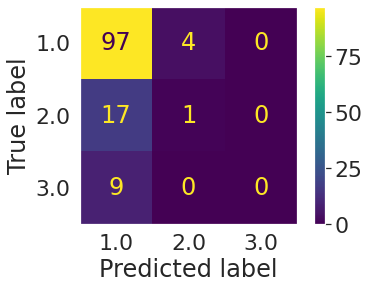

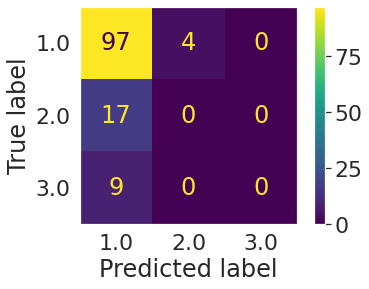

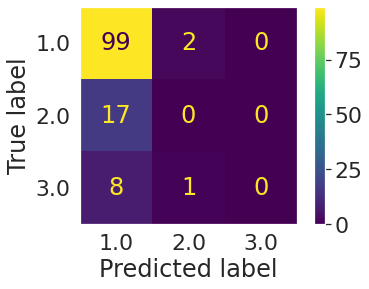

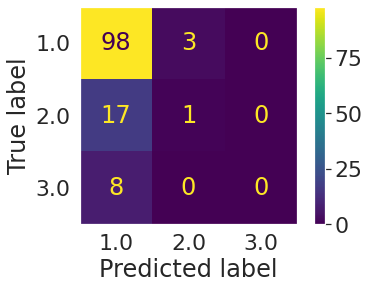

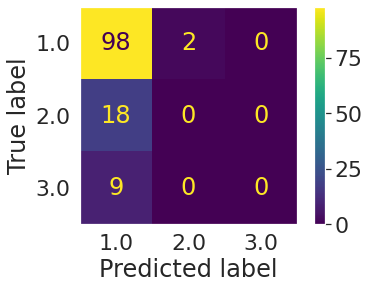

In [456]:
clf_KNN(X_Data, Y_Lavel, 'BloodPressure')

In [457]:
knn_res

,BloodPressure_KNN
0,0.765625
1,0.763780
2,0.779528
3,0.779528
4,0.771654


# With Glucose as Target

In [458]:
def categorize_GL(data_GL):
    #Oral glucose tolerance test
    GL = "Glucose"
    try:
        norm_i = data_GL.loc[(data_GL[GL] <= 140)] # normal
        elevated_i = data_GL.loc[(data_GL[GL] > 140) & (data_GL[GL] < 200)] #prediabetic
        high_i =  data_GL.loc[data_GL[GL] >= 200] #risk

        data_GL[GL][norm_i.index] = 1
        data_GL[GL][elevated_i.index] = 2
        data_GL[GL][high_i.index] = 3
     
    except:
        pass
    
    return data_GL

In [459]:
data_GL = swap_col('Glucose')
print(data_GL.head()), data_GL.shape

   Pregnancies  Diabetic  ...   Age  Glucose
0          6.0         1  ...  50.0    148.0
1          1.0         0  ...  31.0     85.0
2          8.0         1  ...  32.0    183.0
3          1.0         0  ...  21.0     89.0
4          5.0         0  ...  30.0    116.0

[5 rows x 9 columns]


(None, (636, 9))

In [460]:
data_GL = categorize_GL(data_GL)

In [461]:
data_GL.Glucose.value_counts()

1.0    499
2.0    137
Name: Glucose, dtype: int64

In [462]:
data_GL.columns = ['F' + str(i) for i in range(1,9)]+['Outcome'] #Renaming

In [463]:
X_Data,Y_Lavel = feature_Selector(data_GL, algo='PCA', n_feature=8)  

Analyzing **KNN**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         1.0       0.81      0.91      0.86       100
         2.0       0.44      0.25      0.32        28

    accuracy                           0.77       128
   macro avg       0.62      0.58      0.59       128
weighted avg       0.73      0.77      0.74       128




Accuracy for Current Fold: 0.765625

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         1.0       0.83      0.93      0.88        99
         2.0       0.56      0.32      0.41        28

    accuracy                           0.80       127
   macro avg       0.70      0.63      0.64       127
weighted avg       0.77      0.80      0.77       127




Accuracy for Current Fold: 0.7952755905511811

--------------------------------------------------
Det

<Figure size 576x360 with 0 Axes>

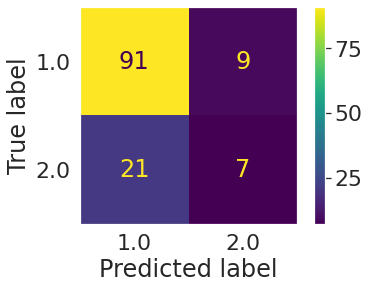

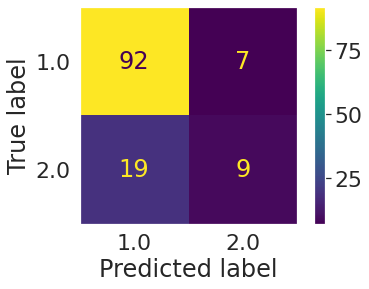

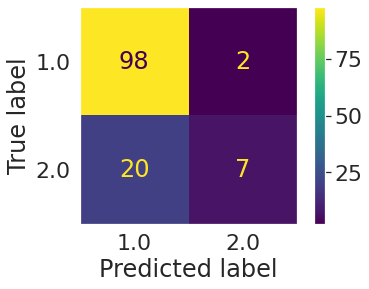

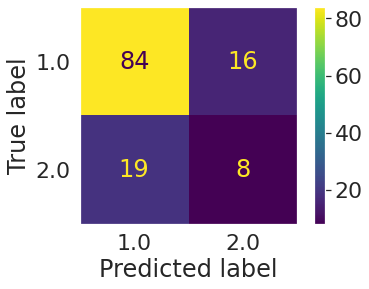

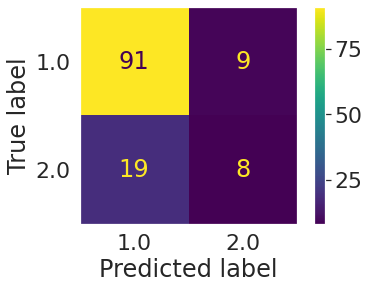

In [464]:
clf_KNN(X_Data, Y_Lavel, 'Glucose')

In [465]:
knn_res

,BloodPressure_KNN,Glucose_KNN
0,0.765625,0.765625
1,0.763780,0.795276
2,0.779528,0.826772
3,0.779528,0.724409
4,0.771654,0.779528
